# Classificador de Imagens usando TensorFlow Estimators

Neste notebook iremos implementadar um modelo para classificação de imagens. Classificação é uma das "tarefas" em que podemos utilizar Machine Learning, nesta tarefa o ensino é **supervisionado**, em outras palavras nós vamos ensinar ao modelo através de exemplos com gabarito.

Nosso modelo deverá receber imagens de gatos e cachorros e identificar a que **classe** (gato ou cachorro) estas imagens pertencem.

## Dados

Os dados foram retirados da base de dados [CIFAR 10](https://www.cs.toronto.edu/~kriz/cifar.html) que contém 10000 imagens de 10 classes distintas, para este exemplo iremos utilizar apenas as classes gato e cachorro.

## Modelo

Iremos utilizar diferentes modelos com diferentes níveis de complexidade.

## Créditos

Essa atividade é baseada no notebook encontrado [aqui](https://github.com/random-forests/tensorflow-workshop/tree/master/extras/cat_dog_estimator) implementada originalmente por [@chrisying](https://github.com/chrisying).

Além disso para mais informações sobre Estimators [este](goo.gl/DBeUkN) é um ótimo material para mais detalhes!


Obrigada a todos os envolvidos!

## Dependências

In [11]:
# Compatibilidade entre Python 2 e Python 3
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# TensorFlow
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)  # Permitindo visualização de logs

# Bibliotecas auxiliares
import cPickle  # maior eficiência ao processar as imagens
import numpy as np  # manipular vetores
from PIL import Image  # lidar com imagens
import matplotlib.pyplot as plt  # plotar imagens
%matplotlib inline

# IMPORTANTE: essa linha garante que os números gerados aleatoriamente são previsíveis
np.random.seed(0)

print ('Sua versão do TensorFlow:', tf.__version__)
print ('Recomenda-se para esta atividade uma versão >= 1.4.0')

Sua versão do TensorFlow: 1.4.1
Recomenda-se para esta atividade uma versão >= 1.4.0


## Buscando os Dados

### Baixa e estraia os dados

Para baixar os dados, execute os seguintes comandos na pasta em que se encontra este notebook.

```bash
curl -O http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar xvf cifar-10-python.tar.gz
```

Ou você pode baixar os dados manualmente [clicando neste link](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) e extraí-los nesta pasta.

Após extrair as pastas você deverá ver as seguintes subpastas:

```bash
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
```

## Salvando as imagens no formato .npy

Para facilitar a manipulação das imagens iremos salvá-las como vetores utilizando a [biblioteca Numpy](http://www.numpy.org/) que é muito fácil de se trabalhar além de ser altamente compatível com o TensorFlow.


In [57]:
ARQUIVOS_TREINO = ['cifar-10-batches-py/data_batch_%d' % i for i in range(1,6)]
ARQUIVOS_TESTE = ['cifar-10-batches-py/test_batch']

NUM_DADOS_TREINO = 10000
NUM_DADOS_TESTE = 2000

LABEL_INPUT_GATO = 3
LABEL_INPUT_CACHORRO = 5

LABEL_OUTPUT_GATO = 1
LABEL_OUTPUT_CACHORRO = 0

def unpickle(file):
    '''Essa função apenas torna mais eficiente a manipulação dos dados, não se preocupe em entendê-la a fundo.'''
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
        return dict
    
def converter_para_numpy(arquivos, num_dados, saida_numpy):
    '''Essa função converte os arquivos de treino e teste em arquivos .npy'''
    
    # Recupera cada dado (imagem, label) nos arquivos
    dados = [unpickle(a) for a in arquivos]

    # Salva as imagens e labels em arrays numpy
    imagens = np.empty((num_dados, 32, 32, 3), dtype=np.uint8)
    labels = np.empty((num_dados), dtype=np.uint8)

    index = 0
    for d in dados:
        for batch_index, label in enumerate(d['labels']):
            # Caso a imagem seja classificada como gato ou cachorro a consideramos
            if label == LABEL_INPUT_GATO or label == LABEL_INPUT_CACHORRO:
                # Os dados originais são armazenados no formato 1 x 3072 , convertemos para 32 x 32 x 3
                imagens[index, :, :, :] = np.transpose(
                  np.reshape(d['data'][batch_index, :],
                  newshape=(3, 32, 32)),
                  axes=(1, 2, 0))
                # Salvamos o label de saída correto
                if label == LABEL_INPUT_GATO:
                    labels[index] = LABEL_OUTPUT_GATO
                else:
                    labels[index] = LABEL_OUTPUT_CACHORRO
                index += 1

    # Salvamos no arquivo de saída
    np.save(saida_numpy, {'imagens': imagens, 'labels': labels})

# Convertendo os arquivos de treino
converter_para_numpy(ARQUIVOS_TREINO, NUM_DADOS_TREINO, 'treino.npy')
# Convertendo os arquivos de teste
converter_para_numpy(ARQUIVOS_TESTE, NUM_DADOS_TESTE, 'teste.npy')

## Verificando se dados foram salvos corretamente

Após manipular ou modificar os dados é sempre importante garantir que os dados estão no formato esperado e não foram corrompidos ou alterados indevidamente. Para isto vamos escolher algumas imagens do conjunto de treino aleatoriamente e verificá-las.

> IMPORTANTE: para modelos reais é importante garantir a qualidade e integridade dos dados com maior rigor já que é fundamental a "saúde" dos dados para se obter um bom modelo.


In [12]:
# Carregando os dados de treino 
dados_treino = np.load('treino.npy').item()

# Carregando os dados de teste 
# NÃO DEVEMOS OLHAR/MEXER NOS DADOS DE TESTE. SÓ UTILIZAREMOS ESTES DADOS PARA VALIDAR NOSSO
# MODELO DEPOIS DO TREINO.
dados_teste = np.load('teste.npy').item()

In [13]:
print ('Formato das imagens de treino:', dados_treino['imagens'].shape)
print ('Número de labels de treino:', dados_treino['labels'].shape[0])
print ('-' * 50)
print ('Formato das imagens de teste:', dados_teste['imagens'].shape)
print ('Número de labels de teste:', dados_teste['labels'].shape[0])

Formato das imagens de treino: (10000, 32, 32, 3)
Número de labels de treino: 10000
--------------------------------------------------
Formato das imagens de teste: (2000, 32, 32, 3)
Número de labels de teste: 2000


Exemplos de 5 imagens da base de treino


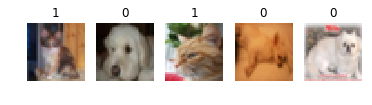

In [14]:
def visualizar_dados_treino(num_dados):
    '''Essa função apresenta alguns dados de treino (imagens, labels) escolhidos aleatoriamente.
       Parâmetros:
           num_dados (int): número de dados que serão apresentados 
    '''

    print('Exemplos de %d imagens da base de treino' % num_dados)
    
    # Escolhemos índices aleatórios
    random_indices = np.random.randint(0, dados_treino['imagens'].shape[0], num_dados)
    
    # Buscando imagens e labels
    imagens = dados_treino['imagens'][random_indices]
    labels = dados_treino['labels'][random_indices]
    
    # Plottando imagens
    for index, (img, label) in enumerate(zip(imagens, labels)):
        plt.subplot(2, num_dados, index + 1)
        plt.axis('off')
        plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('%i' % label)
    plt.show()

visualizar_dados_treino(5)

## Implementando o modelo

### Hiper-parâmetros

In [15]:
# Checkpoints e logs serão salvos nessa paste, se quiser treinar do zero
# delete a pasta ou tudo que tem nela.
MODEL_DIR = 'models'

# Hiper parâmetros
LEARNING_RATE = 0.01
MOMENTUM = 0.9
TRAIN_EPOCHS = 10
BATCH_SIZE = 32

### Modelo

In [16]:
def model_fn(features, labels, mode):
  """Defines the CNN model that runs on the data.

  The model we run is 3 convolutional layers followed by 1 fully connected
  layer before the output. This is much simpler than most CNN models and is
  designed to run decently on CPU. With a GPU, it is possible to scale to
  more layers and more filters per layer.

  Args:
      features: batch_size x 32 x 32 x 3 uint8 images
      labels: batch_size x 1 uint8 labels (0 or 1)
      mode: TRAIN, EVAL, or PREDICT

  Returns:
      EstimatorSpec which defines the model to run
  """

  # Preprocessando as features para o intervalo [-0.5, 0.5]
  features = tf.cast(features, tf.float32)
  features = (features / 255.0) - 1.0

  # Define the CNN network
  # conv1: 32 x 32 x 3 -> 32 x 32 x 16
  conv1 = tf.layers.conv2d(
      inputs=features,
      filters=16,                 # 16 channels after conv
      kernel_size=3,              # 3x3 conv kernel
      padding='same',             # Output tensor is same shape
      activation=tf.nn.relu)      # ReLU activation

  # pool1: 32 x 32 x 16 -> 16 x 16 x 16
  pool1 = tf.layers.max_pooling2d(
      inputs=conv1,
      pool_size=2,
      strides=2)                  # Downsample 2x

  # conv2: 16 x 16 x 16 -> 16 x 16 x 32
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=3,
      padding='same',
      activation=tf.nn.relu)

  # pool2: 16 x 16 x 32 -> 8 x 8 x 32
  pool2 = tf.layers.max_pooling2d(
      inputs=conv2,
      pool_size=2,
      strides=2)

  # conv3: 8 x 8 x 32 -> 8 x 8 x 64
  conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=64,
      kernel_size=3,
      padding='same',
      activation=tf.nn.relu)

  # flat: 8 x 8 x 64 -> 4096
  flat = tf.contrib.layers.flatten(conv3)

  # dense: 4096 -> 1000
  dense = tf.layers.dense(
      inputs=flat,
      units=1000,
      activation=tf.nn.relu)

  # saida: 1000 -> 2
  saida = tf.layers.dense(
      inputs=dense,
      units=2)

  # Softmax -> gera valores similares a probabilidades
  probs = tf.nn.softmax(saida)

  predicao = tf.argmax(
      input=probs,
      axis=1,
      output_type=tf.int32)

  # Return maximum prediction if we're running PREDICT
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={
            'predicao': predicao,
            'probabilidade': probs})

  # Função "loss" e optimizer
  loss = tf.losses.softmax_cross_entropy(
      onehot_labels=tf.one_hot(labels, depth=2),
      logits=saida)

  op_treino = tf.train.MomentumOptimizer(
      LEARNING_RATE, MOMENTUM).minimize(
          loss=loss,
          global_step=tf.train.get_global_step())
  
  # Métricas para avaliar modelo
  metricas_eval = {
      'acuracia': tf.metrics.accuracy(
          labels=labels,
          predictions=predicao)}

  # EVAL uses loss and eval_metric_ops, TRAIN uses loss and train_op
  return tf.estimator.EstimatorSpec(
      mode=mode,
      loss=loss,
      train_op=op_treino,
      eval_metric_ops=metricas_eval)

### Função de entrada

In [17]:
def wrapper_funcao_entrada(treino, dados):
    """Wrapper para função de entrada de treino e teste.

       Vamos utilizar um wrapper para implementar comportamentos ligeiramente
       distintos para treino (iremos randomizar a ordem dos dados e dar um "loop" nos dados)
       e avaliação (não iremos mudar a ordem dos dados).

       Args:
           treino: bool for if the model is training

       Returns:
           função de entrada com a seguinte assinatura: () -> features, labels
    """
    def funcao_entrada():
        """Iremos usar uma função de entrada já implementada para utilizar um array numpy."""
        funcao_np = tf.estimator.inputs.numpy_input_fn(
            x={'x': dados['imagens']},
            y=dados['labels'],
            batch_size=BATCH_SIZE,
            shuffle=treino,  # se for treino -> randomiza a ordem dos dados
            num_epochs=None if treino else 1)  # se for treino -> loop nos dados

        features_dict, labels = funcao_np()
        # Since the only feature is the image itself, return the image directly
        # instead of the features dict
        return features_dict['x'], labels

    return funcao_entrada

## Treinando o modelo

In [18]:
# Create the estimator object that is used by train, evaluate, and predict
# Note that model_fn is not called until the first usage of the model.
estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=tf.estimator.RunConfig().replace(model_dir=MODEL_DIR))

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f02a87a4dd0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'models', '_save_summary_steps': 100}


In [78]:
steps_por_epoch = dados_treino['imagens'].shape[0] / BATCH_SIZE

for epoch in xrange(TRAIN_EPOCHS):
    estimator.train(input_fn=input_fn_wrapper(True, dados_treino),
                  steps=steps_por_epoch)
    # Evaluating on the same dataset as training for simplicity, normally
    # this is a very bad idea since you are not testing how well your
    # model generalizes to unseen data.
    estimator.evaluate(input_fn=input_fn_wrapper(False, dados_teste))

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd64c3678d0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'models', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into models/model.ckpt.
INFO:tensorflow:loss = 0.696027, step = 1
INFO:tensorflow:global_step/sec: 13.1656
INFO:tensorflow:loss = 0.683823, step = 101 (7.597 sec)
INFO:tensorflow:global_step/sec: 13.2627
INFO:tensorflow:loss = 0.705159, step = 201 (7.540 sec)
INFO:tensorflow:global_step/sec: 13.2985
INFO:tensorflow:loss = 0.722643, step = 301 (7.520 sec)
INFO:tensorflow:Saving chec

INFO:tensorflow:loss = 0.635211, step = 2805 (7.503 sec)
INFO:tensorflow:Saving checkpoints for 2817 into models/model.ckpt.
INFO:tensorflow:Loss for final step: 0.40515.
INFO:tensorflow:Starting evaluation at 2017-12-03-20:41:44
INFO:tensorflow:Restoring parameters from models/model.ckpt-2817
INFO:tensorflow:Finished evaluation at 2017-12-03-20:41:46
INFO:tensorflow:Saving dict for global step 2817: acuracia = 0.729, global_step = 2817, loss = 0.548405
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from models/model.ckpt-2817
INFO:tensorflow:Saving checkpoints for 2818 into models/model.ckpt.
INFO:tensorflow:loss = 0.331935, step = 2818
INFO:tensorflow:global_step/sec: 13.2863
INFO:tensorflow:loss = 0.313908, step = 2918 (7.527 sec)
INFO:tensorflow:global_step/sec: 13.3821
INFO:tensorflow:loss = 0.478253, step = 3018 (7.473 sec)
INFO:tensorflow:global_step/sec: 13.3699
INFO:tensorflow:loss = 0.344709, step = 3118 (7.481 sec)
INFO:tensorflow:Saving che

In [23]:
def processar_imagem(path_imagem):
    """Essa função converte uma imagem PIL para o formato esperado pelo modelo.
    
       Operações:
          - Carrega a imagem
          - Da um "crop" na imagem, mantendo apenas o centro da imagem.
          - Muda o tamanho da imagem para 32 x 32
          - Converte a imagem para o formato numpy

       Parâmetros:
           path_imagem (str): path da imagem. Imagem deve ser RGB com pelo menos 32 x 32 píxels.

       Retorna:
           numpy.array com formato [1, 32, 32, 3]
    """
    
    # Carregando a imagem
    img = Image.open(path_imagem)

    # Calculando como cortar a imagem
    largura, altura = img.size

    min_dim = min(largura, altura)
    esquerda = (largura - min_dim) / 2
    topo = (altura - min_dim) / 2
    direita = (largura + min_dim) / 2
    baixo = (altura + min_dim) / 2

    # Cortando imagem e mantendo apenas o centro
    img = img.crop((esquerda, topo, baixo, direita))
    
    # Mudando o tamanho da imagem para 32 x 32
    img = img.resize((32, 32), resample=Image.BILINEAR)
    
    # Convertando a imagem para o formato numpy
    img = np.asarray(img, dtype=np.uint8)
    img = np.reshape(img, [1, 32, 32, 3])

    return img

def predicao_wrapper(img):
    '''Wrapper para função de entrada de predição.'''
    def funcao_entrada_predicao():
        funcao_np = tf.estimator.inputs.numpy_input_fn(
          x={'x': img},
          num_epochs=1,
          shuffle=False)
        features_dict = funcao_np()
        return features_dict['x']
    return funcao_entrada_predicao

def plot_imagem(img):
    '''Plota a imagem.'''
    img = np.reshape(img, (32, 32, 3))
    plt.imshow(img)
    plt.show()

def get_predicao(path_imagem):
    '''Formata imagem corretamente e busca predição.'''

    # Formata a imagem corretamente
    img = processar_imagem(path_imagem)

    # Plota imagem
    plot_imagem(img)

    # Busca predição
    pred_dict = estimator.predict(
        input_fn=predicao_wrapper(img)).next()

    print ('Probabilidade de ser gato: %.5f\tProbabilidade de ser cachorro: %.5f' % (pred_dict['probabilidade'][1], pred_dict['probabilidade'][0]))
    print ('Predição %s' % ('GATO' if pred_dict['predicao'] == 1 else 'CACHORRO'))

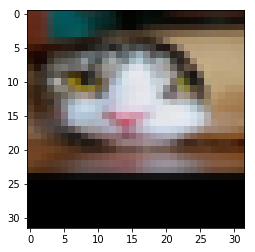

INFO:tensorflow:Restoring parameters from models/model.ckpt-3130
Probabilidade de ser gato: 0.86999	Probabilidade de ser cachorro: 0.13001
Predição GATO


In [26]:
get_predicao('imgs/gato3.jpg')

## Próximos passos

Há várias formas de melhorar a acurácia do modelo a mais óbiva é "tunar" o modelo, isto é, mudar os hiper-parâmetros do nosso modelo buscando sempre um modelo que generaliza melhor. Exemplos de hiper-parâmetros são:

* Mudar o algoritmo de optimização, estamos usando Adam que é bem popular e conhecido mas é interessante tentar outros algoritmos.
* Mudar o tamanho do passo do algoritmo de optimização.
* Arquitetura da CNN - adicionar mais camadas, retirar camadas, mudar o número de nós em cada camada, etc.
* Adicionar dropout
* E muito mais...

Poderíamos também utilizar uma técnica chamada [transfer learning](http://cs231n.github.io/transfer-learning/)